Loading data from datasets

In [1]:
import pandas as pd

data_train = pd.read_csv("sample_data/train.tsv", sep="\t", header=None)
data_valid = pd.read_csv("sample_data/valid.tsv", sep="\t", header=None)
data_test = pd.read_csv("sample_data/test.tsv", sep="\t", header=None)

In [2]:
#Viewing sample train data before preprocessing
data_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


In [3]:
#Viewing sample train data counts
data_train.shape

(10240, 14)

In [4]:
#Viewing count of data in seprate of labels
# Filter the DataFrame based on the label
filtered_data1 = data_train[data_train.iloc[:, 1] ==  'false']
filtered_data2 = data_train[data_train.iloc[:, 1]  == "pants-fire"]
filtered_data3 = data_train[data_train.iloc[:, 1]  == "true"]
filtered_data4 = data_train[data_train.iloc[:, 1]  == "mostly-true"]
filtered_data5 = data_train[data_train.iloc[:, 1]  == "half-true"]
filtered_data6 = data_train[data_train.iloc[:, 1]  == "barely-true"]
# Display the result
print(f"The number of rows with label false is: {filtered_data1.shape[0]}")
print(f"The number of rows with label pants-fire is: {filtered_data2.shape[0]}")
print(f"The number of rows with label true is: {filtered_data3.shape[0]}")
print(f"The number of rows with label mostly-true is: {filtered_data4.shape[0]}")
print(f"The number of rows with label half-true is: {filtered_data5.shape[0]}")
print(f"The number of rows with label barely-true is: {filtered_data6.shape[0]}")

The number of rows with label false is: 1995
The number of rows with label pants-fire is: 839
The number of rows with label true is: 1676
The number of rows with label mostly-true is: 1962
The number of rows with label half-true is: 2114
The number of rows with label barely-true is: 1654


convert 6 classes to 2 classes

In [5]:
def combine_classes(dataset):
    #Creating new column called 'label' with 1 for true and mostly-true values, else 0 i.e. 1=real, 0=fake
    dataset['label']=[1 if x=="true"or x=="mostly-true" else 0 for x in dataset[1]]
    
    #Dealing with empty datapoints for metadata columns - subject, speaker, job, state,affiliation, context
    meta = []
    for i in range(len(dataset)):
      subject = dataset[3][i]
      if subject == 0:
          subject = 'None'

      speaker =  dataset[4][i]
      if speaker == 0:
          speaker = 'None'

      job =  dataset[5][i]
      if job == 0:
          job = 'None'

      state =  dataset[6][i]
      if state == 0:
          state = 'None'

      affiliation =  dataset[7][i]
      if affiliation == 0:
          affiliation = 'None'

      context =  dataset[13][i]
      if context == 0 :
          context = 'None'

      meta.append(str(subject) + ' ' + str(speaker) + ' ' + str(job) + ' ' + str(state) + ' ' + str(affiliation) + ' ' + str(context)) #combining all the meta data columns into a single column
  
    #Adding cleaned and combined metadata column to the dataset
    dataset[14] = meta
    #dataset["sentence"] = dataset[14].astype('str')+" "+dataset[2] #Combining metadata and the text columns into single columns
    dataset["sentence"] = dataset[2]
    
    #Dropping unwanted columns
    dataset = dataset.drop(labels=[0,1,2,3,4,5,6,7,8,9,10,11,12,13] ,axis=1)
    dataset.dropna() #Dropping if there are still any null values
    return dataset

In [6]:
#Applying reduce_classes to the raw data - train, valid and test sets
data_train = combine_classes(data_train)
data_valid = combine_classes(data_valid)
data_test = combine_classes(data_test)
data_train.head(3)


,label,14,sentence
0,0,abortion dwayne-bohac State representative Tex...,Says the Annies List political group supports ...
1,0,"energy,history,job-accomplishments scott-surov...",When did the decline of coal start? It started...
2,1,foreign-policy barack-obama President Illinois...,"Hillary Clinton agrees with John McCain ""by vo..."


In [7]:
#Viewing count of data in seprate of labels
data_train['label'].value_counts(normalize='true')

0    0.644727
1    0.355273
Name: label, dtype: float64

Preproccesing

In [8]:
#importing required packages  
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

def data_preprocessing(dataset):
    preprocessed_texts = []
    for text in dataset:
        # convert to lowercase
        text = text.lower()    
        # tokenize text
        tokens = word_tokenize(text)
        # remove punctuation and irrelevant characters
        filtered_tokens = [token for token in tokens if token.isalnum()]
        # remove stop words
        stop_words = set(stopwords.words('english'))
        filtered_tokens = [token for token in filtered_tokens if not token in stop_words]
        # lemmatize tokens
        lemmatizer = WordNetLemmatizer()
        filtered_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
        # stem tokens
        stemmer = PorterStemmer()
        filtered_tokens = [stemmer.stem(token) for token in filtered_tokens]
        # join tokens back into string
        preprocessed_text = ' '.join(filtered_tokens)
        preprocessed_texts.append(preprocessed_text)
    return preprocessed_texts

In [9]:
#Applying pre-processing to the raw data - train, valid and test sets
data_train['sentence'] = data_preprocessing(data_train['sentence'])
data_valid['sentence'] = data_preprocessing(data_valid['sentence'])
data_test['sentence'] = data_preprocessing(data_test['sentence'])

data_train["sentence"] = data_train["sentence"] + " " + data_train[14].astype('str') #Combining metadata and the text columns into single columns
data_valid["sentence"] = data_valid["sentence"] + " " + data_valid[14].astype('str') #Combining metadata and the text columns into single columns
data_test["sentence"] = data_test["sentence"] + " " + data_test[14].astype('str') #Combining metadata and the text columns into single columns

data_train = data_train.drop(labels=[14] ,axis=1)
data_valid = data_valid.drop(labels=[14] ,axis=1)
data_test = data_test.drop(labels=[14] ,axis=1)

#Sample data after preprocessing
data_train.head(5)

,label,sentence
0,0,say anni list polit group support abort demand...
1,0,declin coal start start natur ga took start be...
2,1,hillari clinton agre john mccain vote give geo...
3,0,health care reform legisl like mandat free sex...
4,0,"econom turnaround start end term economy,jobs ..."


Feature engineering

In [11]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# def feature_engineering(dataset):
#     preprocessed_texts = dataset['sentence']   
#     tfidf_vect = TfidfVectorizer(ngram_range=(2, 2))
#     tfidf_matrix = tfidf_vect.fit_transform(preprocessed_texts)
#     tfidf_matrix.sort_indices()
#     return tfidf_matrix

In [12]:
# from sklearn.decomposition import TruncatedSVD

# def reduce_dimension_SVD(data_matrix):
#     svd_model = TruncatedSVD(n_components=200)
#     svd_matrix = svd_model.fit_transform(data_matrix)
#     return svd_matrix

In [13]:
# #Applying feature_engineering to the preproccessed data - train, valid and test sets
# X_features_train = feature_engineering(data_train)
# X_features_valid = feature_engineering(data_valid)
# X_features_test = feature_engineering(data_test)

# # X_features_train = reduce_dimension_SVD(X_features_train)
# # X_features_valid = reduce_dimension_SVD(X_features_valid)
# # X_features_test = reduce_dimension_SVD(X_features_test)
# print(X_features_train.shape[1])


83596


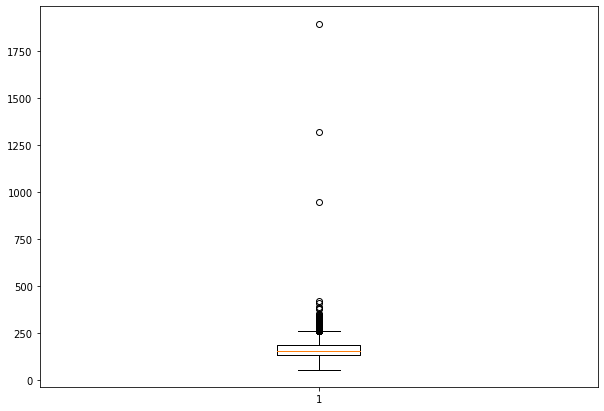

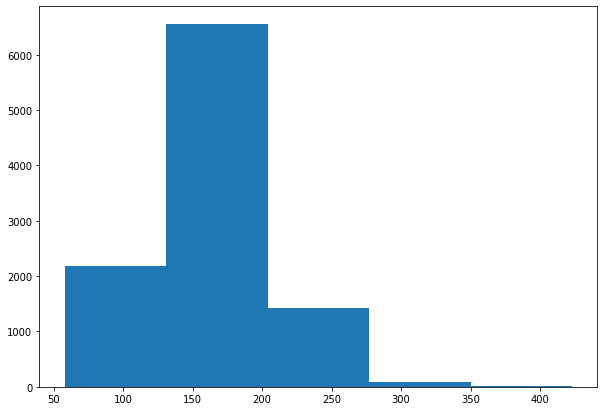

In [13]:
#Analyzing length of sentences in training data to decide on MAX_LENGTH variable, which is required for mlp and deep_leaner

sent_len = []
for sent in data_train['sentence']:
  sent_len.append(len(sent))

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(10, 7))
plt.boxplot(sent_len)
plt.show()

sent_len = [i for i in sent_len if i<=500] #Excluding the outliers
fig2 = plt.figure(figsize =(10, 7))
plt.hist(sent_len, 5)
plt.show()

First plot:The x-axis represents the sentence length, while the y-axis represents the distribution of lengths.

Second Histogram: It shows a histogram of the sentence lengths after excluding any outliers greater than 500 characters From the above histogram. The x-axis represents the range of sentence lengths, divided into bins (in this case, 5 bins), and the y-axis represents the frequency or count of sentences falling within each bin.The histogram provides insight into the distribution of sentence lengths and highlights any patterns or concentration of lengths within the dataset.

we can see that, majority of the sentences are in the range of 100-150 and the maximum is near 300.

In [ ]:
#Vectorize
data_train_valid = pd.concat([data_train, data_valid])
X_train_valid = data_train_valid['sentence']
y_train_valid = data_train_valid['label']
X_test = data_test['sentence']
y_test = data_test['label']

tdif_vec=TfidfVectorizer(stop_words= 'english',max_df=0.7) 
xtrain_vec=tdif_vec.fit_transform(X_train_valid)
xtest_vec=tdif_vec.transform(data_test)

#Apply Models
classifiers=[PassiveAggressiveClassifier(max_iter=50),SVC(),LogisticRegression(max_iter=150),RandomForestClassifier(random_state=0),MultinomialNB()]
predictions=[]
model_time=[]
auc_scores=[]
for i in classifiers:
    start = time.time() 
    Fit=i.fit(xtrain_vec,y_train_valid)
    end = time.time()
    mt=end-start #Measures the different training times for each model
    model_time.append(mt)
    pred=Fit.predict(xtest_vec)
    predictions.append(pred)
    if 'decision_function' in dir(i):
        confidence_val=i.decision_function(xtest_vec)
        auc = roc_auc_score(y_test,confidence_val)
        auc_scores.append(auc)
    else:
        confidence_val=i.predict_proba(xtest_vec)[::,1]
        auc = roc_auc_score(y_test,confidence_val)
        auc_scores.append(auc)
  
#Evaluation
accuracy_scores=[]
f1_scores=[]
for i in predictions:
    accuracy_scores.append(accuracy_score(y_test,i))
    f1_scores.append(f1_score(y_test, i, average='macro'))

model_eval = pd.DataFrame(list(zip(auc_scores,accuracy_scores,f1_scores,model_time)), index =['PassiveAggressive', 'SVC', 'LogisticRegression','Random Forest','Naive Bayes'],
                                              columns =['AUC','Accuracy','F1','Train_time(sec)'])
model_eval.sort_values(by='AUC',ascending=False)

Ensemble Model

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils.vis_utils import plot_model

def create_ensemble_models(X_train, y_train, X_val, y_val):
    num_models = 3
    models = []
    
    for i in range(num_models):
        model = Sequential()
        
        model.add(Embedding(vocab_size, 100, input_length=max_len))
        model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, name=f'lstm_layer_{i}'))
        #model.add(Dense(64, activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)
        
        models.append(model)

    return models

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import GlorotNormal as xavier_glorot_initialization

def create_ensemble_models1(X_train, y_train, X_val, y_val):
    num_models = 2
    models = []
    
    for i in range(num_models):
        #weights = xavier_glorot_initialization(seed=None)
        model = Sequential()
        model.add(Embedding(vocab_size, 100, input_length=max_len))     
        model.add(Dense(128, activation='relu' ))      
        model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))                   
        model.add(Dense(32, activation='relu' ))
        model.add(Dense(16, activation='relu' ))
        model.add(Dense(1, activation='sigmoid' ))

        #plot_model(model, to_file='neural_network.png', show_shapes=True)
        
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=5, batch_size=64)
        
        models.append(model)
    return models

In [15]:
def get_ensemble_weights(X_valid, y_valid, models):
    weights = []
    for model in models:
        accuracy = model.evaluate(X_valid, y_valid)[1]
        weights.append(accuracy)

    total_weights = sum(weights)
    normalized_weights = [weight / total_weights for weight in weights]

    return normalized_weights

In [45]:
import numpy as np

def predict_ensemble_models(X_valid, X_test, y_valid, y_test, models, weights):
    # Make predictions on the validation set
    y_pred_ensemble_valid = np.zeros_like(y_valid, dtype=np.float64)
    for i in range(len(models)):
        y_pred_valid = models[i].predict(X_valid)
        y_pred_ensemble_valid += np.squeeze((y_pred_valid > 0.5).astype(int)) * weights[i]

    y_pred_ensemble_valid /= np.sum(weights)
    y_pred_ensemble_valid = np.round(y_pred_ensemble_valid).astype(int)

    # Make predictions on the test set
    y_pred_ensemble = np.zeros_like(y_test, dtype=np.float64)
    for i in range(len(models)):
        y_pred = models[i].predict(X_test)
        y_pred_ensemble += np.squeeze((y_pred > 0.5).astype(int)) * weights[i]

    y_pred_ensemble /= np.sum(weights)
    y_pred_ensemble = np.round(y_pred_ensemble).astype(int)

    return y_pred_ensemble_valid, y_pred_ensemble

In [38]:
#part 1
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train['sentence'])
vocab_size = len(tokenizer.word_index) + 1

X_train = tokenizer.texts_to_sequences(data_train['sentence'])
X_valid = tokenizer.texts_to_sequences(data_valid['sentence'])
X_test = tokenizer.texts_to_sequences(data_test['sentence'])

max_len = 150  # Define the maximum sequence length
X_train = pad_sequences(X_train, maxlen=max_len)
X_valid = pad_sequences(X_valid, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

y_train = np.array(data_train['label'])  # Convert to numpy array
y_valid = np.array(data_valid['label'])  # Convert to numpy array
y_test = np.array(data_test['label'])  # Convert to numpy array

In [41]:
#Part2 : Create ensemble model
models = create_ensemble_models(X_train, y_train,X_valid, y_valid)

Epoch 1/5
160/160 [==============================] - 95s 579ms/step - loss: 0.6358 - accuracy: 0.6441 - val_loss: 0.6011 - val_accuracy: 0.6729
Epoch 2/5
160/160 [==============================] - 95s 591ms/step - loss: 0.5694 - accuracy: 0.6935 - val_loss: 0.5992 - val_accuracy: 0.6846
Epoch 3/5
160/160 [==============================] - 96s 601ms/step - loss: 0.4735 - accuracy: 0.7686 - val_loss: 0.6139 - val_accuracy: 0.6776
Epoch 4/5
160/160 [==============================] - 99s 621ms/step - loss: 0.3819 - accuracy: 0.8268 - val_loss: 0.7282 - val_accuracy: 0.6604
Epoch 5/5
160/160 [==============================] - 99s 620ms/step - loss: 0.3032 - accuracy: 0.8662 - val_loss: 0.8297 - val_accuracy: 0.6223
Epoch 1/5
160/160 [==============================] - 93s 570ms/step - loss: 0.6362 - accuracy: 0.6450 - val_loss: 0.5924 - val_accuracy: 0.6799
Epoch 2/5
160/160 [==============================] - 90s 562ms/step - loss: 0.5600 - accuracy: 0.7062 - val_loss: 0.6103 - val_accuracy:

In [42]:
weights_ensemble = get_ensemble_weights(X_valid, y_valid, models)


41/41 [==============================] - 2s 45ms/step - loss: 0.7981 - accuracy: 0.6433


In [43]:
weights_ensemble

[0.32217742473042094, 0.34475805157491257, 0.3330645236946665]

In [46]:
y_pred_ensemble_valid, y_pred_ensemble = predict_ensemble_models(X_valid, X_test, y_valid, y_test, models,weights_ensemble)

40/40 [==============================] - 2s 42ms/step


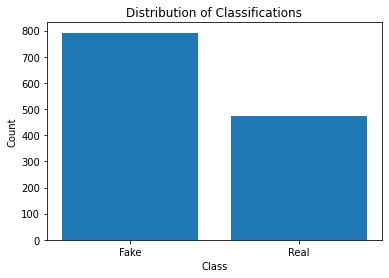

In [47]:
#Visualizing distribution of predeiction of ensemble clas
class_counts = np.bincount(y_pred_ensemble)
# Create a bar plot
plt.bar(range(len(class_counts)), class_counts)
class_labels = ['Fake', 'Real']

# Set the x-axis tick labels to the class labels
plt.xticks(range(len(class_counts)), class_labels)

# Set the plot title and axes labels
plt.title('Distribution of Classifications')
plt.xlabel('Class')
plt.ylabel('Count')

# Display the plot
plt.show()

In [48]:
from sklearn.metrics import f1_score, classification_report

# Print classification report
f_score = f1_score(data_test['label'], y_pred_ensemble, average='micro')
print("Ensemble F1-score:", f_score)
print("Classification Report:")
print(classification_report(data_test['label'], y_pred_ensemble))

Ensemble F1-score: 0.6053670086819258
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.68      0.69       818
           1       0.45      0.47      0.46       449

    accuracy                           0.61      1267
   macro avg       0.57      0.58      0.57      1267
weighted avg       0.61      0.61      0.61      1267



Custom MLP Classifier

In [8]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [9]:
from transformers import (
    mlpForSequenceClassification,    
    mlpTokenizer,
    deep_leanerForSequenceClassification,
    deep_leanerTokenizer,
    AdamW)

# Loading mlp base model
mlp_model = mlpForSequenceClassification.from_pretrained("mlp-base-uncased", #Using mlp base model with an uncased vocab.
                                                                num_labels = 2, #number of output labels - 0,1 (binary classification)
                                                                output_attentions = False, #model doesnt return attention weights
                                                                output_hidden_states = False #model doesnt return hidden states
                                                          )
#mlp tokenizer
mlp_tokenizer = mlpTokenizer.from_pretrained("mlp-base-uncased", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
mlp_model.cuda()

# Loading deep_leaner base model
deep_leaner_model = deep_leanerForSequenceClassification.from_pretrained("deep_leaner-base", #deep_leaner base model
                                                                    num_labels = 2,  #number of output labels - 0,1 (binary classification)
                                                                    output_attentions = False,  #model doesnt return attention weights
                                                                    output_hidden_states = False #model doesnt return hidden states
                                                                )
#deep_leaner tokenizer
deep_leaner_tokenizer = deep_leanerTokenizer.from_pretrained("deep_leaner-base", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
deep_leaner_model.cuda()

print(' Base models loaded') 

ImportError: cannot import name 'mlpForSequenceClassification' from 'transformers' (c:\users\diba\appdata\local\programs\python\python39\lib\site-packages\transformers\__init__.py)

MLP Classifier

In [40]:
weights=[]
weights.append(models[0].layers[1].get_weights())
weights.append(models[1].layers[1].get_weights())
weights.append(models[2].layers[1].get_weights())


In [44]:
from sklearn.neural_network import MLPClassifier

def build_mlp():
    # Step 1: increase the training data with ensemble predictions
    X_train_increased = np.concatenate((X_valid, y_pred_ensemble_valid[:len(X_valid)].reshape(-1, 1)), axis=1)
    #X_train_increased = np.concatenate([X_valid] + reshaped_weights + [y_pred_ensemble_valid[:len(X_valid)].reshape(-1, 1)], axis=1)

    mlp_classifier = MLPClassifier()
    mlp_classifier.fit(X_train_increased, y_valid)

    X_test_increased = np.concatenate((X_test, y_pred_ensemble.reshape(-1, 1)), axis=1)
    #X_test_increased = np.concatenate([X_test] + reshaped_weights + [y_pred_ensemble[:len(X_test)].reshape(-1, 1)], axis=1)

    mlp_predictions = mlp_classifier.predict(X_test_increased)
    return mlp_predictions

In [45]:


mlp_predictions = build_mlp()

In [47]:
from sklearn.metrics import accuracy_score

# Calculate F-score and accuracy
f_score = f1_score(y_test, mlp_predictions, average='micro')
accuracy = accuracy_score(y_test, mlp_predictions)
print(classification_report(y_test, mlp_predictions))

print("MLP F-score:", f_score)
print("MLP Accuracy:", accuracy)

              precision    recall  f1-score   support

           0       0.64      0.64      0.64       818
           1       0.34      0.35      0.34       449

    accuracy                           0.53      1267
   macro avg       0.49      0.49      0.49      1267
weighted avg       0.53      0.53      0.53      1267

MLP F-score: 0.5327545382794001
MLP Accuracy: 0.5327545382794001
